In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *

from pathlib import Path
from torchvision.transforms.functional import to_pil_image
from data import get_image
import matplotlib.pyplot as plt

import pycocotools
from pycocotools.coco import COCO

# Intro

In [3]:
# --- 1. Define Paths ---
data_dir = Path(CONFIG['datasets']['COCO2017_root_path'])
data_type = 'val2017' # or 'train2017'
ann_file = data_dir / 'annotations' / f'instances_{data_type}.json'
# ann_file = os.path.join(data_dir, 'annotations', f'instances_{data_type}.json')
img_dir = data_dir / data_type
# img_dir = os.path.join(data_dir, data_type)

# --- 2. Initialize COCO API ---
# This will load the JSON file into memory and build indexing structures.
coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [4]:
# --- 3. Get Category and Image Information ---
# Get all category IDs
cat_ids = coco.getCatIds()
# Load all categories
cats = coco.loadCats(cat_ids)
# Print category names
print("Categories:")
for cat in cats[:10]:
    print(f"ID: {cat['id']}, Name: {cat['name']}")
print("...")

# Get all image IDs in the dataset
img_ids = coco.getImgIds()
print(f"\nTotal images: {len(img_ids)}")

Categories:
ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
...

Total images: 5000


In [5]:
# --- 4. Load a Specific Image and its Annotations ---
# Let's pick one image to demonstrate
image_id = img_ids[10] # You can pick any index or a specific ID

# Load image metadata
img_info = coco.loadImgs([image_id])[0]
print(f"\nImage Info: {img_info}")


Image Info: {'license': 3, 'file_name': '000000296649.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000296649.jpg', 'height': 427, 'width': 640, 'date_captured': '2013-11-15 15:26:19', 'flickr_url': 'http://farm4.staticflickr.com/3577/3491669985_d81e1050c6_z.jpg', 'id': 296649}


In [6]:
# Construct the full image path
image_path = img_dir / img_info['file_name']
# image_path = os.path.join(img_dir, img_info['file_name'])
image = Image.open(image_path).convert('RGB')

In [7]:
# --- 5. Generate the Semantic Segmentation Mask ---
# Create an empty mask with the same dimensions as the image
mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8) # class 0 is not in the dataset, it is added by us here

In [8]:
# Get all annotation IDs for this image
ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
# Load all annotations
anns = coco.loadAnns(ann_ids)

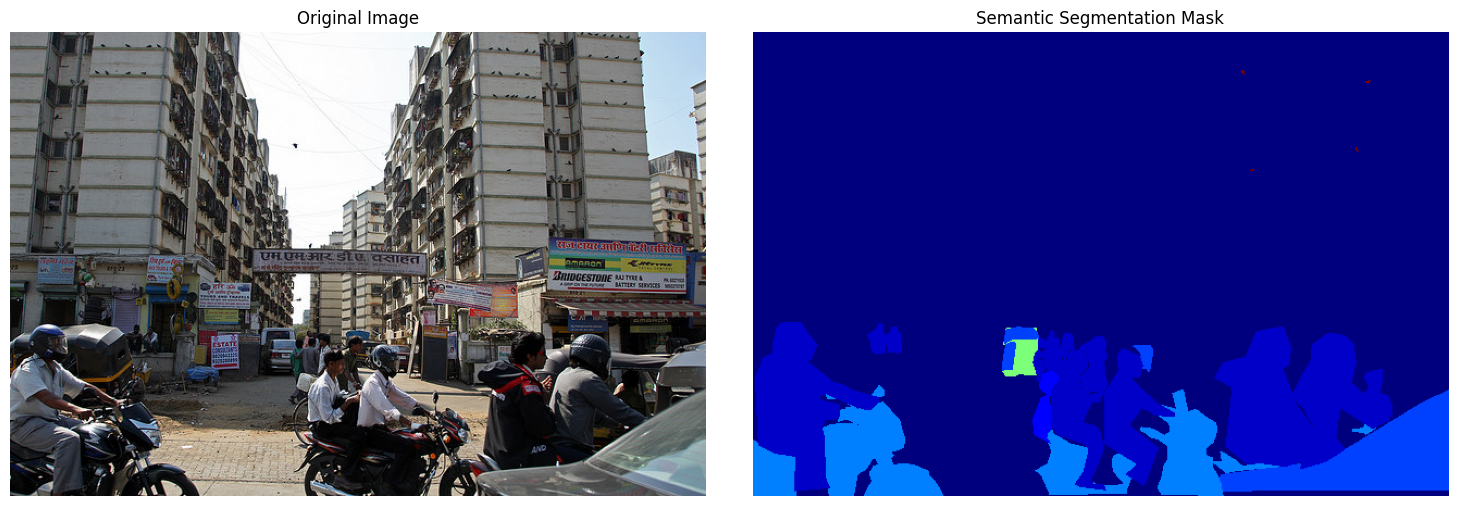


Unique values in the mask (0 is background): [ 0  1  2  3  4  8 16]


In [9]:
for ann in anns:
    category_id = ann['category_id']
    # coco.annToMask() creates a binary mask for a single annotation
    instance_mask = coco.annToMask(ann)
    # Add the instance mask to the main mask, using the category_id as the pixel value
    mask[instance_mask == 1] = category_id

# --- 6. Visualize the Results ---
plt.figure(figsize=(15, 5))

# Plot Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Plot Semantic Segmentation Mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='jet') # Using 'jet' or other colormaps helps visualize different classes
plt.title('Semantic Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# You can also inspect the unique values in your mask
print("\nUnique values in the mask (0 is background):", np.unique(mask))

In [10]:
coco.loadCats(np.unique(mask)[1:])

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'}]

# COCO2017SegDataset

In [3]:
from data import COCO2017SegDataset
from color_map import apply_colormap
from utils import blend_tensors

In [4]:
coco_dataset = COCO2017SegDataset(
    root_path=Path(CONFIG['datasets']['COCO2017_root_path']),
    split='train',
    resize_size=CONFIG['seg']['image_size'],
    center_crop=True,
    only_VOC_labels=True
)
len(coco_dataset)

loading annotations into memory...
Done (t=21.36s)
creating index...
index created!


95279

In [ ]:
coco_dataset.image_UIDs[15593:15603]

array([ 73560, 541197, 496152, 229713,   7260,  57283, 244633, 490280,
       526801, 330050])

In [9]:
scs, gts = coco_dataset[:1]

In [10]:
idx = 0

sc = scs[idx]
gt = gts[idx]
gt.unique()

tensor([ 0,  1, 15, 19], device='cuda:0', dtype=torch.uint8)

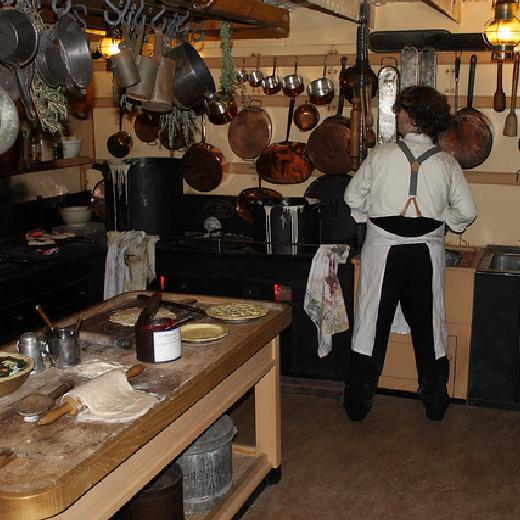

In [11]:
to_pil_image(sc)

In [ ]:
apply_colormap(s)

---

In [3]:
from data import ImageCaptionDataset, ImageDataset, JSONLDataset

In [9]:
mask_color: str = 'L'

ImageCaptionDataset(
        ImageDataset(Path(f'/home/olivieri/exp/data/data_gen/COCO2017/l1_train/images_{mask_color}')),
        JSONLDataset(Path('/home/olivieri/exp/data/data_gen/COCO2017/l1_train/captions.jsonl')),
),

(<data.ImageCaptionDataset at 0x7f527a054b50>,)